<a href="https://colab.research.google.com/github/dcovarru/Python/blob/master/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid Data Example

In this notebook we will download publicly available Covid-19 data and perform Exploratory Data Analysis using Python and Jupyter.

This Section is created using Markdown
More to come!

Import packages
In this Section we will import the necessary Pythgon "packages" to execute our Notebook
Packages are add-on's to basic Python.  We will be creating a simple package in (Add Section/notebook)


# Import Packages

In this section we will import the packages.

Tip: I almost always import pandas and numpy. 

In [2]:
#####################
# Import packages
#####################

import pandas as pd
import numpy as np
import dateutil
import datetime
import pandas_datareader
import pandas_datareader.data as web
from pandas_datareader.data import get_quote_yahoo
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix
import os
import re
import plotly.figure_factory as ff
import plotly as py
import plotly.offline as offline
import plotly.graph_objects as go
import plotly.express as px
from google.colab import drive
plt.style.use('seaborn-whitegrid')
import io

import seaborn as sns
%matplotlib inline

# Accessing Data

In [3]:
#####################
# Import NYT data 
#####################

covidData = pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv')

# https://github.com/nytimes/covid-19-data
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data

#####################
# helper sites #
#####################

# https://medium.com/@deallen7/managing-date-datetime-and-timestamp-in-python-pandas-cc9d285302ab#83e5
# https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

# Inspecting Data

In [4]:
covidData['date'].max()

'2020-10-24'

In [5]:
# ensure Date is data
# covidData.dtypes
# covidData['date'] = covidData['date'].apply(dateutil.parser.parse, dayfirst=True)
covidData['date_dtFormat'] = pd.to_datetime(covidData['date'])
# covidData

In [6]:
covidData.dtypes

date                     object
county                   object
state                    object
fips                    float64
cases                     int64
deaths                    int64
date_dtFormat    datetime64[ns]
dtype: object

# ETL of Data

In [7]:
#####################
# ETL data 
#####################
covidData[['date_dtFormat']]
covidData.loc[:,['date_dtFormat']]

,date_dtFormat
0,2020-01-21
1,2020-01-22
2,2020-01-23
3,2020-01-24
4,2020-01-24
...,...
664142,2020-10-24
664143,2020-10-24
664144,2020-10-24
664145,2020-10-24


In [8]:
covidData

,date,county,state,fips,cases,deaths,date_dtFormat
0,2020-01-21,Snohomish,Washington,53061.0,1,0,2020-01-21
1,2020-01-22,Snohomish,Washington,53061.0,1,0,2020-01-22
2,2020-01-23,Snohomish,Washington,53061.0,1,0,2020-01-23
3,2020-01-24,Cook,Illinois,17031.0,1,0,2020-01-24
4,2020-01-24,Snohomish,Washington,53061.0,1,0,2020-01-24
...,...,...,...,...,...,...,...
664142,2020-10-24,Sweetwater,Wyoming,56037.0,456,2,2020-10-24
664143,2020-10-24,Teton,Wyoming,56039.0,743,1,2020-10-24
664144,2020-10-24,Uinta,Wyoming,56041.0,428,3,2020-10-24
664145,2020-10-24,Washakie,Wyoming,56043.0,144,7,2020-10-24


In [9]:
#####################
# Aggregate by Week
#####################

# covidData.tail(30)
# df['date_time'].dt.strftime('%Y-%U')
# covidData['date_dtFormat'].dt.strftime('%Y-%w')
# covidData['date_dtFormat2'] = covidData['date_dtFormat'].dt.strftime('"%A %d %B %Y"')
# covidData['date_dtFormat'].dt.strftime('%b %d %Y')

# Extract Week
covidData['data_week'] = covidData['date_dtFormat'].dt.week
# Extract Month
covidData['data_month'] = covidData['date_dtFormat'].dt.month
# Extract DOW
covidData['data_dow'] = covidData['date_dtFormat'].dt.dayofweek

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [10]:
covidData

,date,county,state,fips,cases,deaths,date_dtFormat,data_week,data_month,data_dow
0,2020-01-21,Snohomish,Washington,53061.0,1,0,2020-01-21,4,1,1
1,2020-01-22,Snohomish,Washington,53061.0,1,0,2020-01-22,4,1,2
2,2020-01-23,Snohomish,Washington,53061.0,1,0,2020-01-23,4,1,3
3,2020-01-24,Cook,Illinois,17031.0,1,0,2020-01-24,4,1,4
4,2020-01-24,Snohomish,Washington,53061.0,1,0,2020-01-24,4,1,4
...,...,...,...,...,...,...,...,...,...,...
664142,2020-10-24,Sweetwater,Wyoming,56037.0,456,2,2020-10-24,43,10,5
664143,2020-10-24,Teton,Wyoming,56039.0,743,1,2020-10-24,43,10,5
664144,2020-10-24,Uinta,Wyoming,56041.0,428,3,2020-10-24,43,10,5
664145,2020-10-24,Washakie,Wyoming,56043.0,144,7,2020-10-24,43,10,5


In [11]:
################################
# Calculate Difference for Daily Total
################################

## covidData['daily_deaths'] = covidData['deaths'].diff()
# covidData.groupby['deaths'].diff()
# df.groupby(level=0)['values'].diff()
covidData['daily_cases'] = covidData.groupby(['state', 'county'])['cases'].diff()
covidData['daily_deaths'] = covidData.groupby(['state', 'county'])['deaths'].diff()
# covidData.shape

In [12]:
covidData.tail()

,date,county,state,fips,cases,deaths,date_dtFormat,data_week,data_month,data_dow,daily_cases,daily_deaths
664142,2020-10-24,Sweetwater,Wyoming,56037.0,456,2,2020-10-24,43,10,5,5.0,0.0
664143,2020-10-24,Teton,Wyoming,56039.0,743,1,2020-10-24,43,10,5,3.0,0.0
664144,2020-10-24,Uinta,Wyoming,56041.0,428,3,2020-10-24,43,10,5,3.0,0.0
664145,2020-10-24,Washakie,Wyoming,56043.0,144,7,2020-10-24,43,10,5,1.0,0.0
664146,2020-10-24,Weston,Wyoming,56045.0,127,0,2020-10-24,43,10,5,6.0,0.0


In [13]:
################################
# Verify data
################################

covidData[(covidData.state == 'Wyoming') & (covidData.county=='Washakie')].tail(20)

,date,county,state,fips,cases,deaths,date_dtFormat,data_week,data_month,data_dow,daily_cases,daily_deaths
602509,2020-10-05,Washakie,Wyoming,56043.0,120,6,2020-10-05,41,10,0,2.0,0.0
605751,2020-10-06,Washakie,Wyoming,56043.0,119,6,2020-10-06,41,10,1,-1.0,0.0
608994,2020-10-07,Washakie,Wyoming,56043.0,118,6,2020-10-07,41,10,2,-1.0,0.0
612236,2020-10-08,Washakie,Wyoming,56043.0,122,6,2020-10-08,41,10,3,4.0,0.0
615477,2020-10-09,Washakie,Wyoming,56043.0,122,6,2020-10-09,41,10,4,0.0,0.0
618719,2020-10-10,Washakie,Wyoming,56043.0,123,6,2020-10-10,41,10,5,1.0,0.0
621962,2020-10-11,Washakie,Wyoming,56043.0,124,6,2020-10-11,41,10,6,1.0,0.0
625205,2020-10-12,Washakie,Wyoming,56043.0,125,6,2020-10-12,42,10,0,1.0,0.0
628448,2020-10-13,Washakie,Wyoming,56043.0,126,7,2020-10-13,42,10,1,1.0,1.0
631692,2020-10-14,Washakie,Wyoming,56043.0,131,7,2020-10-14,42,10,2,5.0,0.0


In [14]:
####################
# Create aggreate Week Month Counts (yay...)
#####################

# df.groupby(['Name', 'Fruit'])['Number'].agg('sum')
# covidData.groupby(['data_week']).sum()
#################################################
# Below is aggregate the sum by dimensions 
#################################################
# covidData_aggState = covidData.groupby(['state','data_week'])['deaths'].agg('sum').to_frame().reset_index()

# covidData_aggState = covidData.groupby(['state','county','data_week'], as_index=False)['daily_deaths'].sum()
covidData_aggState = covidData.groupby(['state','county','data_week'], as_index=False)['daily_cases'].sum()

In [15]:
covidData_aggState

,state,county,data_week,daily_cases
0,Alabama,Autauga,13,5.0
1,Alabama,Autauga,14,6.0
2,Alabama,Autauga,15,7.0
3,Alabama,Autauga,16,8.0
4,Alabama,Autauga,17,10.0
...,...,...,...,...
96819,Wyoming,Weston,39,13.0
96820,Wyoming,Weston,40,6.0
96821,Wyoming,Weston,41,16.0
96822,Wyoming,Weston,42,35.0


In [16]:
# covidData_aggState.to_frame().reset_index()
## covidData_aggState[covidData_aggState.state=='Texas']
covidData_aggState[(covidData_aggState['state'] == "Texas") & (covidData_aggState['county'].isin(['Harris']))].tail(20)

,state,county,data_week,daily_cases
81187,Texas,Harris,24,2192.0
81188,Texas,Harris,25,4275.0
81189,Texas,Harris,26,8223.0
81190,Texas,Harris,27,7321.0
81191,Texas,Harris,28,8771.0
81192,Texas,Harris,29,10401.0
81193,Texas,Harris,30,9580.0
81194,Texas,Harris,31,11293.0
81195,Texas,Harris,32,9115.0
81196,Texas,Harris,33,6496.0


In [17]:
#################################################
# Extract State, County, Start of Week, DOW = 0, and DATE table 
#################################################

covidData_Calendar = covidData[['state', 'county', 'date','data_week','data_dow']].drop_duplicates()[covidData.data_dow == 0]

In [18]:
covidData_aggState_weekly = covidData_aggState.merge(covidData_Calendar, how = 'right', on=['state', 'county', 'data_week'], indicator=True)

In [19]:
covidData_aggState


,state,county,data_week,daily_cases
0,Alabama,Autauga,13,5.0
1,Alabama,Autauga,14,6.0
2,Alabama,Autauga,15,7.0
3,Alabama,Autauga,16,8.0
4,Alabama,Autauga,17,10.0
...,...,...,...,...
96819,Wyoming,Weston,39,13.0
96820,Wyoming,Weston,40,6.0
96821,Wyoming,Weston,41,16.0
96822,Wyoming,Weston,42,35.0


In [20]:
#################################################
# Difference data to get weekly volume 
#################################################

# covidData_aggState[(covidData_aggState['state'] == "Texas") & (covidData_aggState['county'].isin(['Bexar']))]['deaths'].diff(periods=1)
covidData_temp = covidData_aggState_weekly[(covidData_aggState_weekly['state'] == "Texas") & (covidData_aggState_weekly['county'].isin(['Harris']))].sort_values(by=['date'])
covidData_temp

,state,county,data_week,daily_cases,date,data_dow,_merge
197,Texas,Harris,11,7.0,2020-03-09,0,both
624,Texas,Harris,12,61.0,2020-03-16,0,both
1756,Texas,Harris,13,452.0,2020-03-23,0,both
3676,Texas,Harris,14,869.0,2020-03-30,0,both
6081,Texas,Harris,15,2234.0,2020-04-06,0,both
8724,Texas,Harris,16,1194.0,2020-04-13,0,both
11486,Texas,Harris,17,906.0,2020-04-20,0,both
14306,Texas,Harris,18,1109.0,2020-04-27,0,both
17181,Texas,Harris,19,1040.0,2020-05-04,0,both
20166,Texas,Harris,20,1587.0,2020-05-11,0,both


# Quick Analysis

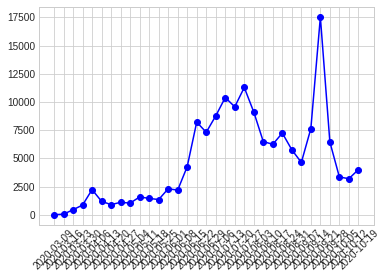

In [21]:
# covidTrace = go.Bar(x = covidData_temp.date, y = covidData_temp.daily_cases)
# fig = go.Figure(data = [covidTrace])
# plotly.offline.plot(fig)

# fig = go.box(covidData_temp, y='daily_cases')
# fig.show()

fig = plt.figure()
ax = plt.axes()
plt.xticks(rotation=45)
ax.plot(covidData_temp.date, covidData_temp.daily_cases, marker='o', color='b')

In [22]:
# plt.figure(figsize=(10,5))
# ax = sns.boxplot(x="date", y="daily_cases", data=a)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [23]:
#####################
# Create Model with metrics?
#####################

In [24]:
#####################
# Trend Diagnostics
#####################